<a href="https://colab.research.google.com/github/ocriado91/SpocMining/blob/5-data-exploration-notebook/notebooks/01_spoc_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SpOC - Mine the Belt Challenge. Data exploration

In the previous [notebook](https://github.com/ocriado91/SpocMining/blob/main/notebooks/00_intro_and_evalution_code.ipynb) we introduced SpoC Mine The Belt Challenge and executed the evaluation example code to obtain a score of `0.58`.

In this notebook, we are to deep understand the data into `candidates.txt`

## Installation from source

These steps are the same as carried out in the previous notebook

In [7]:
# Clone pykep repository if it hasn't been cloned previously.
!if [ ! -d /content/pykep ]; then git clone https://github.com/esa/pykep pykep_source; fi

Cloning into 'pykep_source'...
remote: Enumerating objects: 11876, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 11876 (delta 268), reused 397 (delta 240), pack-reused 11415
Receiving objects: 100% (11876/11876), 58.24 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (7699/7699), done.
Updating files: 100% (2531/2531), done.


### a) Install Keplerian Toolbox library


In [8]:
# Create build folder and move into it
%mkdir /content/pykep_source/build/
%cd /content/pykep_source/build/

# Run CMake
!cmake -DBoost_NO_BOOST_CMAKE=ON \
    -DPYKEP_BUILD_KEP_TOOLBOX=yes \
    -DPYKEP_BUILD_PYKEP=no \
    -DPYKEP_BUILD_SPICE=yes \
    -DPYKEP_BUILD_TESTS=yes \
    -DCMAKE_INSTALL_PREFIX=/usr/local/ \
    -DCMAKE_PREFIX_PATH=/usr/local/ \
    -DCMAKE_BUILD_TYPE=Release \
    ../;

# And execute make
!make VERBOSE=1 -j4 install

/content/pykep_source/build
CMake Deprecation Warning at CMakeLists.txt:5 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- System name: 
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- '-fdiagnostics-color=auto': flag is supported by the compiler, enabling.
-- '-Waddress-of-packed-member': debug flag is supported by the com

### b) Installation pykep Python package

In [9]:
# Create build pykep folder and move into it
%mkdir /content/pykep_source/build_pykep
%cd /content/pykep_source/build_pykep

# Run CMake with pykep building flags enabled
!cmake -DBoost_NO_BOOST_CMAKE=ON \
    -DPYKEP_BUILD_KEP_TOOLBOX=no \
    -DPYKEP_BUILD_PYKEP=yes \
    -DPYKEP_BUILD_TESTS=no \
    -DCMAKE_INSTALL_PREFIX=/usr/local/ \
    -DCMAKE_PREFIX_PATH=/usr/local/ \
    -DCMAKE_BUILD_TYPE=Release \
    ../;
# And execute make
!make VERBOSE=1 install

/content/pykep_source/build_pykep
CMake Deprecation Warning at CMakeLists.txt:5 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- System name: 
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- '-fdiagnostics-color=auto': flag is supported by the compiler, enabling.
-- '-Waddress-of-packed-member': debug flag is supported by t

# First approach of Data Exploration

Once the packages are installed, we can begin with the Data Exploration to extract the first insights of the challenge's data.

## Imports

First of all, we need to import the Python packages that we are going to use into this data exploration. At this moment, just we are going to use:

* `polars`: I'm a very fan of this package due to its performance and I use it into all my data projects.
* `pykep`: Th installed packaged into previous steps.
* `seaborn`: To generate plots.

By default, the version `0.20.2` is installed into Google Colab notebooks, but we want the latest version:

In [10]:
!pip uninstall polars --yes # Remove by default version of polars
!pip install polars==0.20.22 # Install latest version

Found existing installation: polars 0.20.22
Uninstalling polars-0.20.22:
  Successfully uninstalled polars-0.20.22
  Using cached polars-0.20.22-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (27.4 MB)


In [16]:
import matplotlib.pyplot as plt
import polars as pl
import pykep as pk
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/pykep/util/gravity_spherical_harmonic.py:156: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _calculate_normalisation_parameters(n_max):


# Data Exploration
## Reading input data

First of all, we need to download the [dataset](https://api.optimize.esa.int/data/spoc/mining/candidates.txt)

In [12]:
!wget https://api.optimize.esa.int/data/spoc/mining/candidates.txt

--2024-04-27 20:57:36--  https://api.optimize.esa.int/data/spoc/mining/candidates.txt
Resolving api.optimize.esa.int (api.optimize.esa.int)... 195.169.140.114
Connecting to api.optimize.esa.int (api.optimize.esa.int)|195.169.140.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2250000 (2.1M) [text/plain]
Saving to: ‘candidates.txt’

candidates.txt      100%[===================>]   2.15M  2.82MB/s    in 0.8s    

2024-04-27 20:57:37 (2.82 MB/s) - ‘candidates.txt’ saved [2250000/2250000]



And now, we can read it with polars and store it as Dataframe, add the column headers because they are not in the input data file, and cast `ID` and `Material Type` columns as integers to manage easier later.

In [13]:
# Set custom headers
HEADER = ["ID",
          "Semi-major axis [m]",
          "Eccentricity",
          "Inclination [rad]",
          "Ascending Node [rad]",
          "Argument of Periapsis [rad]",
          "True Anomaly [rad]",
          "Mass [0 to 1]",
          "Material Type"]

# Read asteroid candidates file
data = pl.read_csv("candidates.txt",
                   separator=" ",
                   new_columns=HEADER)

# Cast columns
data = data.cast({"ID": pl.UInt16,
           "Material Type": pl.UInt8})

# Show head
data.head()

ID,Semi-major axis [m],Eccentricity,Inclination [rad],Ascending Node [rad],Argument of Periapsis [rad],True Anomaly [rad],Mass [0 to 1],Material Type
u16,f64,f64,f64,f64,f64,f64,f64,u8
1,3.0835e10,0.008338,0.079912,3.912543,5.042492,2.617431,0.65811,3
2,2.3826e10,0.006097,0.006188,4.83121,4.589027,2.075072,0.964783,1
3,3.0512e10,0.001916,0.072551,2.277854,3.250898,1.168246,0.451917,0
4,2.9867e10,0.000553,0.013222,3.530913,4.200775,3.918279,0.668809,2
5,3.3090e10,0.004041,0.103529,2.281561,5.481973,5.145668,0.403246,2


## Analysis

So, once all python packages are installed and the input data read, we can start with our data exploration given answers to a questions:



### Q1. How many asteroids are of each type are?

According to the challenge description, the materials are equally distributed, but this is correct?

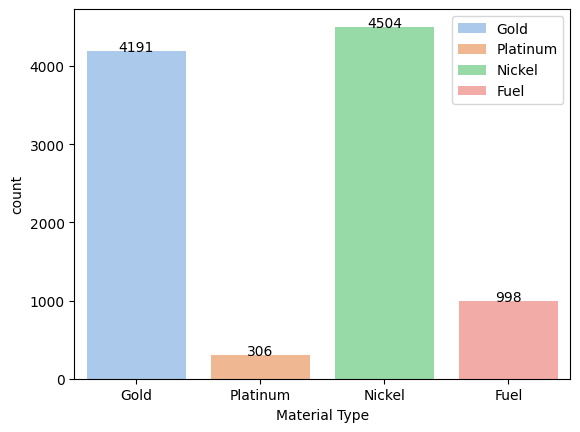

In [14]:
# Plot count
g = sns.countplot(data,
              x="Material Type",
              hue="Material Type",
              palette="pastel")

# Transform X-tick labels and legend label to material name
labels = ["Gold", "Platinum", "Nickel", "Fuel"]
g.set_xticks([0, 1, 2, 3])
g.set_xticklabels(labels)
g.legend(labels=labels)

# Extract the count of asteroids by material type
count_gold = data.filter(pl.col("Material Type") == 0).height
count_platinum = data.filter(pl.col("Material Type") == 1).height
count_nickel = data.filter(pl.col("Material Type") == 2).height
count_fuel = data.filter(pl.col("Material Type") == 3).height

# Add all counts into a list to write its values into countplot
counts = [count_gold, count_platinum, count_nickel, count_fuel]
for i in range(len(counts)):
  g.text(x=i,
         y=counts[i],
         s=str(counts[i]),
         horizontalalignment="center")


Ok, it is clear that ***we don't have a balanced distribution of asteroid by material type.***

### Q2. Is it equally equidistance distributed all asteroid by material type?

After the previous result, we want to know if the asteroids by material are equally distributed into the space. For this purpose, we are going to create a function to transform our DataFrame to a [pykep's planet object](https://esa.github.io/pykep/documentation/planets.html):

In [17]:
# Start and end epochs
ISO_T_START = "30190302T000000"
ISO_T_END = "30240302T000000"

# Cavendish constant (m^3/s^2/kg)
G = 6.67430e-11

# Sun_mass (kg)
SM = 1.989e30

# Mass and Mu of the Trappist-1 star
MS = 8.98266512e-2 * SM
MU_TRAPPIST = G * MS

def convert_to_planet(planet_data: dict) -> pk.planet:
  return pk.planet.keplerian(
      pk.epoch_from_iso_string(ISO_T_START),
      (
          planet_data["Semi-major axis [m]"],
          planet_data["Eccentricity"],
          planet_data["Inclination [rad]"],
          planet_data["Ascending Node [rad]"],
          planet_data["Argument of Periapsis [rad]"],
          planet_data["True Anomaly [rad]"]
      ),
      MU_TRAPPIST,
      G*planet_data['Mass [0 to 1]'],
      1,
      1.1,
      "Asteroid " + str(planet_data["ID"])
  )

And another function to plot the asteroids dataframe using [pykep's plotting module](https://esa.github.io/pykep/documentation/orbitplots.html) (and previously transforming our dataframe to planet objects using the `convert_to_planet` function):

In [18]:
def plot_planets(data: pl.DataFrame,
                 axes):

  # Define a lookup table to select a color in based of material type
  color_lookup = {0: "gold",
                  1: "red",
                  2: "green",
                  3: "blue"}

  ids = data.select(["ID"])
  for row in data.iter_rows(named=True):
    idx = row["ID"]
    planet = convert_to_planet(row)
    color = color_lookup[row["Material Type"]]
    axes = pk.orbit_plots.plot_planet(planet,
                                      axes = axes,
                                      s=2,
                                      alpha=0, # Don't show asteroid orbit plot
                                      color=color)

  return axes

With these functions, we can plot our asteroids data:

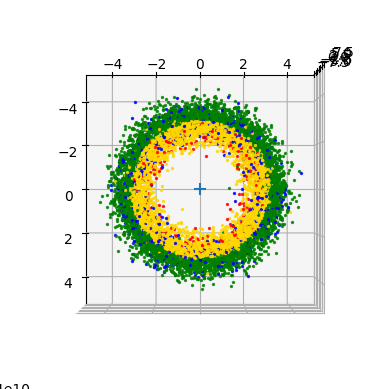

In [19]:
ax = plt.figure().add_subplot(projection="3d")
ax = plot_planets(data, ax)

# Setup X and Y axis limits
ax.set_xlim([-5e10, 5e10])
ax.set_ylim([-5e10, 5e10])

# Configure zenithal view
ax.view_init(elev=90, azim=0)

ax.scatter(0, 0, s=80, marker="+")


There is a huge amount of asteroids data! We are going to try to filter asteroids by material type and plot one by one:

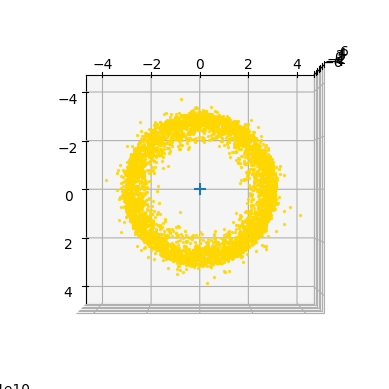

In [20]:
ax = plt.figure().add_subplot(projection="3d")

gold_data = data.filter(pl.col("Material Type") == 0)
ax = plot_planets(gold_data, ax)

# Configure zenithal view
ax.view_init(elev=90, azim=0)
ax.scatter(0, 0, s=80, marker="+")

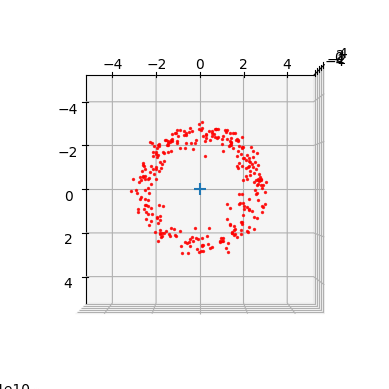

In [21]:
ax = plt.figure().add_subplot(projection="3d")

platinum_data = data.filter(pl.col("Material Type") == 1)
ax = plot_planets(platinum_data, ax)

# Setup X and Y axis limits
ax.set_xlim([-5e10, 5e10])
ax.set_ylim([-5e10, 5e10])

# Configure zenithal view
ax.view_init(elev=90, azim=0)
ax.scatter(0, 0, s=80, marker="+")

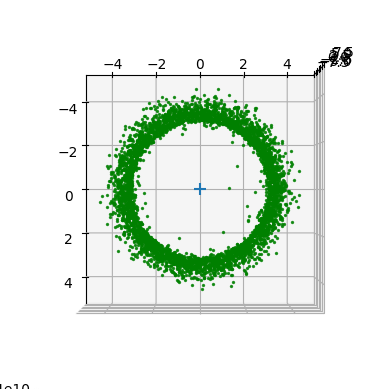

In [22]:
ax = plt.figure().add_subplot(projection="3d")

nickel_data = data.filter(pl.col("Material Type") == 2)
ax = plot_planets(nickel_data, ax)

# Setup X and Y axis limits
ax.set_xlim([-5e10, 5e10])
ax.set_ylim([-5e10, 5e10])

# Configure zenithal view
ax.view_init(elev=90, azim=0)
ax.scatter(0, 0, s=80, marker="+")

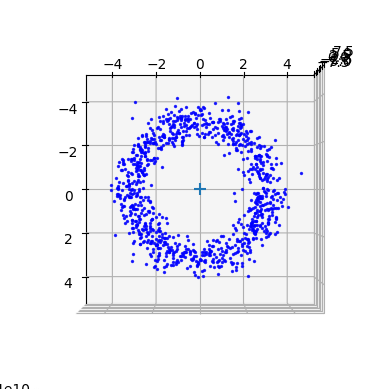

In [23]:
ax = plt.figure().add_subplot(projection="3d")

propellant_data = data.filter(pl.col("Material Type") == 3)
ax = plot_planets(propellant_data, ax)

# Setup X and Y axis limits
ax.set_xlim([-5e10, 5e10])
ax.set_ylim([-5e10, 5e10])

# Configure zenithal view
ax.view_init(elev=90, azim=0)
ax.scatter(0, 0, s=80, marker="+")

This is fine, but we are going to explore the distribution of the Semi-major axis of the orbit by material type to determine if all materials are equally distributed or if there is some type of pattern that we need to know:

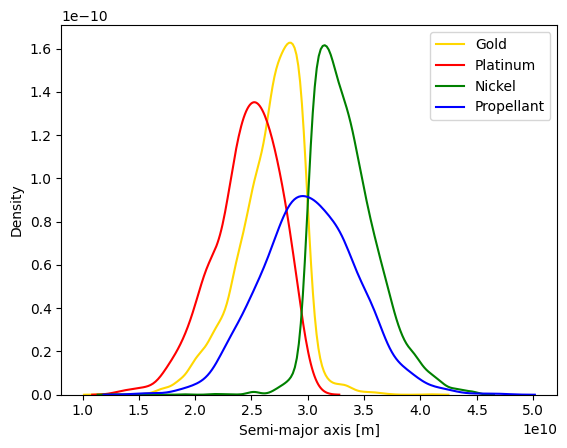

In [24]:
sns.kdeplot(gold_data,
            x="Semi-major axis [m]",
            color="gold",
            label="Gold")

sns.kdeplot(platinum_data,
            x="Semi-major axis [m]",
            color="red",
            label="Platinum")

sns.kdeplot(nickel_data,
            x="Semi-major axis [m]",
            color="green",
            label="Nickel")

ax = sns.kdeplot(propellant_data,
                 x="Semi-major axis [m]",
                 color="blue",
                 label="Propellant")
ax.legend()

As we can see, the `propellant` asteroids are distribution along multiple semi-major axis distances. Also, it can be a good idea to follow a `platinum` -> `gold` -> `nickel` -> `gold` -> `platinum` pattern because of the distance of the orbits.

<Axes: xlabel='Semi-major axis [m]', ylabel='Proportion'>

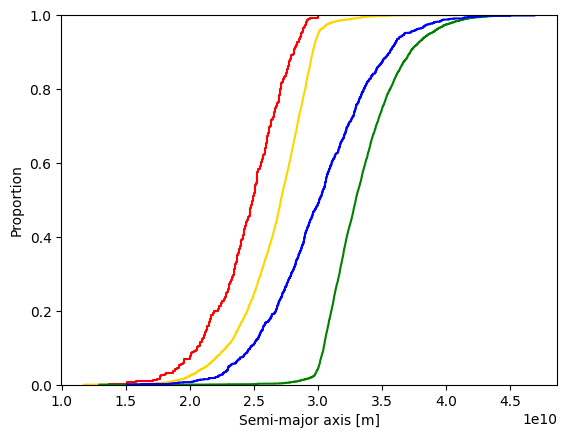

In [26]:
sns.ecdfplot(gold_data,
             x="Semi-major axis [m]",
             color="gold")

sns.ecdfplot(platinum_data,
             x="Semi-major axis [m]",
             color="red")

sns.ecdfplot(nickel_data,
             x="Semi-major axis [m]",
             color="green")

sns.ecdfplot(propellant_data,
             x="Semi-major axis [m]",
             color="blue")